In [1]:
%load_ext autoreload
%autoreload 2

from mapper import map_anywhere as mpa
from mapper import graph_node, build_node_graph, extract_segments, filter_tree, break_loops
from osrm_interface import osrm_handler

import osmium
import shapely.geometry as geom
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np
import pickle

In [2]:
# Simple example
dest_latlon = (47.635639, -122.105031) # Reid and Emma
# dest_latlon = (47.752200, -122.317425) # Rachel and Nikole
# dest_latlon = (36.970433, -122.007613) # Cayla

n_sample = 1000
num_workers = 1

width = 0.5 # deg
height = 0.5 # deg

# nw_latlon = (48.954886, -125.652977)
# se_latlon = (31.133894, -105.457201)

router = mpa(parallel_workers=num_workers)
router.set_destination(dest_latlon)
if width is not None:
    router.set_bounding_box_centered(width, height)
else:
    router.set_bounding_box(nw_latlon, se_latlon)
router.sample_nodes(n_sample)
router.sample_routes(geometry=True)

In [3]:
print(len(router.node_dict))
print(len(router.segment_counts))
print(len(router.lonlat_dict))

945
56053
58975


In [4]:
tree = build_node_graph(router.segment_counts)
filter_tree(tree)
segments = extract_segments(tree)
segments += break_loops(tree)
segments += extract_segments(tree)

Tree is not empty!!!
Found a loop at node 5245199943
Found a loop at node 4272310012
Found a loop at node 6522347739


In [5]:
node_set = set()
for n1n2 in router.segment_counts:
    n1, n2 = n1n2
    node_set.add(n1)
    node_set.add(n2)

In [6]:
nodes_lonlat = router.lonlat_dict
k = next(iter(nodes_lonlat))
nodes_lonlat[k]

[-122.328805, 47.396862]

In [7]:
# Need to extract segments
class segment_t():
    def __init__(self, seg_list, nodes_lonlat):
        # self.weight = np.log(seg_list[0] + 1)
        self.weight = (seg_list[0]) ** 0.25
        self.nodes = seg_list[1]
        self.lon = [nodes_lonlat[n][0] for n in self.nodes]
        self.lat = [nodes_lonlat[n][1] for n in self.nodes]

In [8]:
segment_list = [segment_t(s, nodes_lonlat) for s in segments]

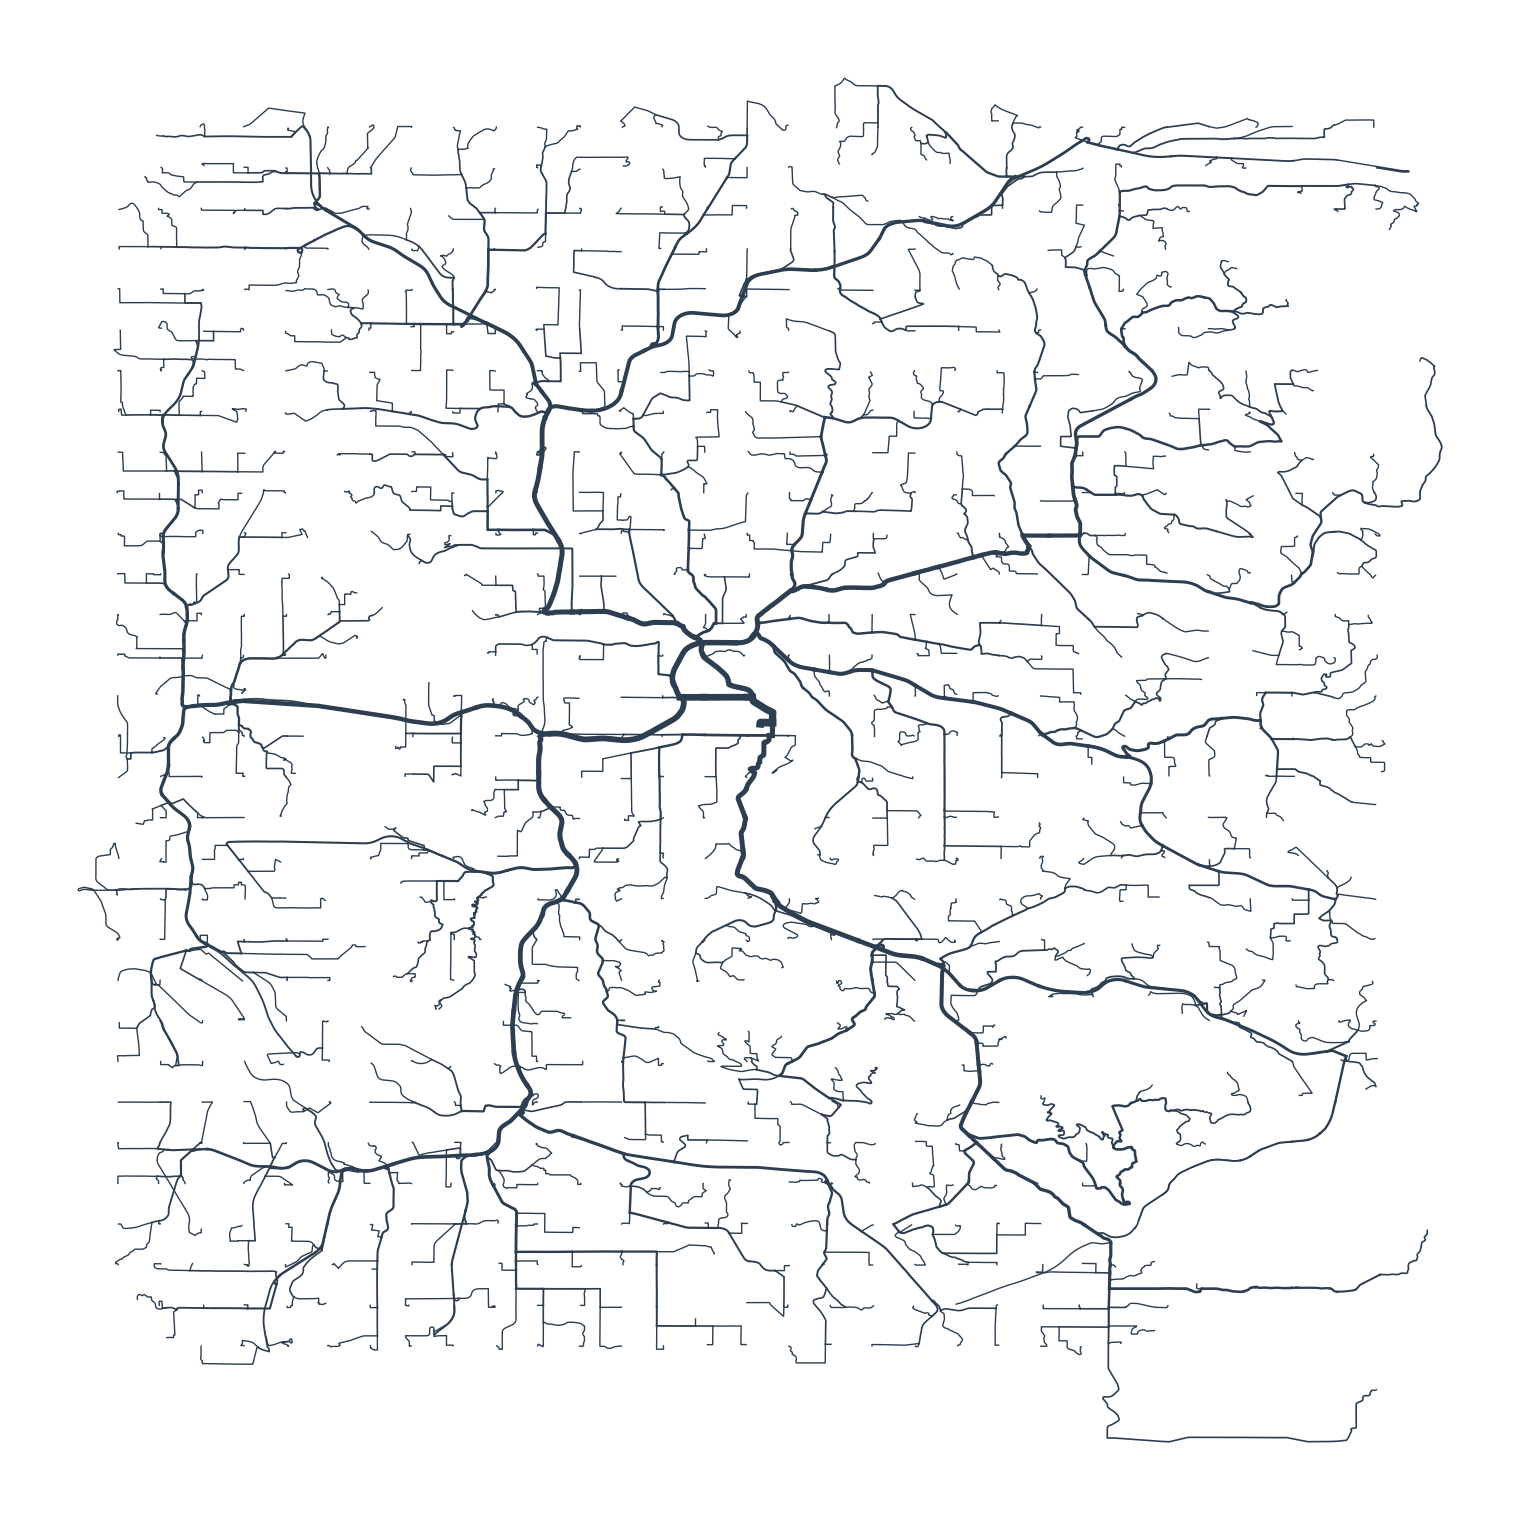

In [9]:
# Plot things, hopefully aesthetically nicely
fig, ax = plt.subplots(figsize=(15, 15), dpi=100)
# ax.set_aspect('equal')

linewidth_scale = 1
for segment in segment_list:
    plt.plot(segment.lon, segment.lat, color='#2C3E50', alpha=1.0, linewidth=segment.weight*linewidth_scale, antialiased=True)

padding = 1.1
# if nw_latlon is not None:
#     pad_w = (se_latlon[1] - nw_latlon[1]) * padding / 2
#     pad_h = (nw_latlon[0] - se_latlon[0]) * padding / 2
#     plt.xlim([nw_latlon[1] - pad_w, se_latlon[1] + pad_w])
#     plt.ylim([se_latlon[0] - pad_h, se_latlon[0] + pad_h])
# else:
#     plt.xlim([dest_latlon[1] - padding * width/2, dest_latlon[1] + padding * width/2])
#     plt.ylim([dest_latlon[0] - padding * height/2, dest_latlon[0] + padding * height/2])

# Styling for aesthetic output
ax.set_facecolor('#ECF0F1')  # Light background
ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig('output.png', dpi=600, bbox_inches='tight', facecolor='#ECF0F1')
plt.show()

In [2]:
class WayNodeHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.nodes = {}
    
    def way(self, w):
        if 'highway' in w.tags:
            for n in w.nodes:
                self.nodes[n.ref] = (n.location.lon, n.location.lat)

In [4]:
handler = WayNodeHandler()
# handler.apply_file("washington-250930.osm.pbf", locations=True)
pbf_file = "us-west-250930.osm.pbf"
handler.apply_file(pbf_file, locations=True)

In [5]:
import pickle

file = f"{pbf_file}.p"

with open(file, 'wb') as f:
    pickle.dump(handler.nodes, f)

# Later, load instantly
with open(file, 'rb') as f:
    latlon_dict = pickle.load(f)